In [1]:
# Importando Bibliotecas

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV  # Ferramentas para dividir dados e otimizar hiperparâmetros.
from sklearn.ensemble import RandomForestRegressor  # Algoritmo de regressão baseado em árvores.
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # Pré-processamento de dados categóricos e numéricos.
from sklearn.compose import ColumnTransformer  # Combinação de preprocessamentos diferentes.
from sklearn.pipeline import Pipeline  # Criação de pipeline para facilitar o fluxo de trabalho.
import numpy as np  # Biblioteca para cálculos numéricos.

In [2]:
# Carregar os dados

# Lê os dados de um arquivo CSV.
data = pd.read_csv('..\\..\\data\\processed\\final_data.csv')

In [3]:
# Separar features e target

# X: Todas as colunas usadas como entrada (features) para o modelo.
# y: A coluna 'VALOR_FATURA', que é a variável alvo (o que queremos prever).
X = data.drop(columns=['VALOR_FATURA', 'DATA_VENCIMENTO', 'MATRICULA'])
y = data['VALOR_FATURA']

In [4]:
# Identificar colunas categóricas e numéricas

# Define quais colunas são categóricas e quais são numéricas para o pré-processamento.
categorical_features = ['BAIRRO']  # Exemplo: localização.
numerical_features = ['VOLUME_FATURA_AGUA', 'VOLUME_FATURA_ESGOTO', 'VOLUME_MEDIDO_AGUA', 'VOLUME_MEDIDO_ESGOTO', 'ANO_VENCIMENTO', 'MES_VENCIMENTO']

In [5]:
# Pré-processamento

# Configura um transformador para aplicar diferentes preprocessamentos às colunas:
# - StandardScaler: Normaliza valores numéricos (para que todos tenham média 0 e desvio padrão 1).
# - OneHotEncoder: Converte valores categóricos em formato binário.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Aplica escalonamento aos dados numéricos.
        ('cat', OneHotEncoder(), categorical_features)  # Aplica codificação one-hot aos dados categóricos.
    ]
)

In [6]:
# Modelo

# Define o modelo que será usado para a previsão.
# RandomForestRegressor: Um modelo baseado em árvores que combina previsões de múltiplas árvores de decisão.
model = RandomForestRegressor(random_state=42)

In [7]:
# Pipeline

# Junta o pré-processamento e o modelo em um único pipeline.
# O pipeline facilita o fluxo de dados e garante que os passos sejam aplicados corretamente.
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Primeiro aplica o pré-processamento.
    ('regressor', model)  # Depois ajusta o modelo.
])

In [8]:
# Hiperparâmetros para Random Search

# Define os hiperparâmetros que serão testados para o modelo.
# Esses parâmetros influenciam o funcionamento interno do modelo e devem ser ajustados para melhorar a performance.
param_distributions = {
    'regressor__n_estimators': [50, 100, 150],  # Número de árvores na floresta.
    'regressor__max_depth': [None, 10, 20, 30],  # Profundidade máxima das árvores.
    'regressor__min_samples_split': [2, 5, 10],  # Número mínimo de amostras para dividir um nó.
    'regressor__min_samples_leaf': [1, 2, 4]  # Número mínimo de amostras em cada folha.
}

In [9]:
# Divisão dos dados

# Divide os dados em conjuntos de treino (80%) e teste (20%).
# Isso permite avaliar o desempenho do modelo em dados que ele não viu durante o treinamento.
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Random Search com Cross Validation

# RandomizedSearchCV busca os melhores hiperparâmetros de forma aleatória dentro das opções fornecidas.
random_search = RandomizedSearchCV(
    pipeline,  # Pipeline contendo pré-processamento e modelo.
    param_distributions,  # Espaço de busca dos hiperparâmetros.
    n_iter=10,  # Número de combinações aleatórias a serem testadas.
    cv=3,  # Número de divisões para validação cruzada.
    scoring='neg_mean_absolute_error',  # Métrica de avaliação (erro absoluto médio negativo).
    n_jobs=-1,  # Usa todos os processadores disponíveis para acelerar a busca.
    random_state=42
)

# Ajusta o modelo nos dados de treinamento.
random_search.fit(data_train, target_train)

c:\Users\maype\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['VOLUME_FATURA_AGUA',
                                                                                'VOLUME_FATURA_ESGOTO',
                                                                                'VOLUME_MEDIDO_AGUA',
                                                                                'VOLUME_MEDIDO_ESGOTO',
                                                                                'ANO_VENCIMENTO',
                                                                                'MES_VENCIMENTO']),
                                                                              ('cat',
                                                                               OneHotEncoder(),
                                                                               ['BAIRRO'])])),
                                             ('regressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'regressor__max_depth': [None, 10, 20,
                                                                 30],
                                        'regressor__min_samples_leaf': [1, 2,
                                                                        4],
                                        'regressor__min_samples_split': [2, 5,
                                                                         10],
                                        'regressor__n_estimators': [50, 100,
                                                                    150]},
                   random_state=42, scoring='neg_mean_absolute_error')

In [11]:
# Resultados

# Exibe os melhores hiperparâmetros encontrados e o melhor score.
print("Melhores hiperparâmetros:", random_search.best_params_)
print("Melhor score (MAE negativo):", random_search.best_score_)

Melhores hiperparâmetros: {'regressor__n_estimators': 150, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 4, 'regressor__max_depth': 20}
Melhor score (MAE negativo): nan


In [12]:
# Avaliação no conjunto de teste

# Obtém o modelo treinado com os melhores hiperparâmetros.
best_model = random_search.best_estimator_

# Calcula o desempenho do modelo no conjunto de teste.
test_score = best_model.score(data_test, target_test)
print("Score no conjunto de teste:", test_score)

Score no conjunto de teste: 0.9702283445792511


In [13]:
# Previsões e visualização

# Adiciona previsões do modelo para o conjunto de teste.
data_test_sorted = data_test.copy()  # Cria uma cópia dos dados de teste.
data_test_sorted['VALOR_FATURA_REAL'] = target_test  # Adiciona os valores reais.
data_test_sorted['VALOR_FATURA_PREVISTO'] = best_model.predict(data_test_sorted)  # Adiciona os valores previstos.

# Ordena os dados para facilitar a visualização.
data_test_sorted = data_test_sorted.sort_index()

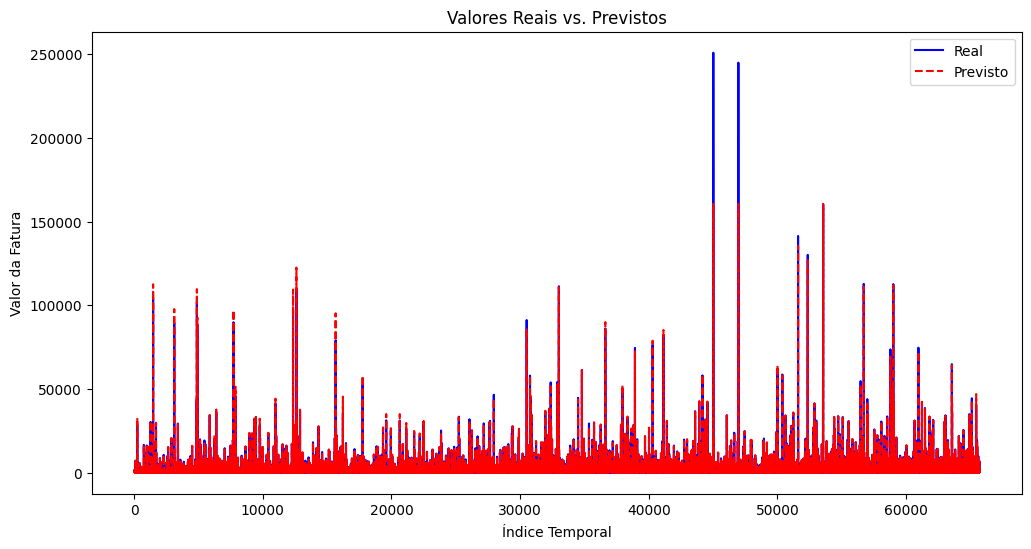

In [14]:
#  

# Plotar resultados
# Cria um gráfico comparando os valores reais e previstos.
plt.figure(figsize=(12, 6))  # Define o tamanho do gráfico.
plt.plot(data_test_sorted.index, data_test_sorted['VALOR_FATURA_REAL'], label='Real', color='blue')
plt.plot(data_test_sorted.index, data_test_sorted['VALOR_FATURA_PREVISTO'], label='Previsto', color='red', linestyle='--')
plt.title('Valores Reais vs. Previstos')
plt.xlabel('Índice Temporal')
plt.ylabel('Valor da Fatura')
plt.legend()  # Adiciona a legenda.
plt.show()

In [15]:
# 

def prever_fatura_com_matricula(matricula, dados_completos, modelo_treinado):
    """
    Função para prever o valor da próxima fatura usando apenas a matrícula.
    
    Args:
        matricula (int): Matrícula para a qual será feita a previsão.
        dados_completos (pd.DataFrame): Conjunto de dados original contendo todas as informações.
        modelo_treinado (Pipeline): Modelo treinado (pipeline).
    
    Returns:
        float: Valor previsto da próxima fatura.
    """
    # Filtrar os dados históricos da matrícula
    dados_matricula = dados_completos[dados_completos['MATRICULA'] == matricula]

    if dados_matricula.empty:
        return f"Erro: Matrícula {matricula} não encontrada nos dados fornecidos."

    # Calcular valores médios ou usar os dados mais recentes
    dados_matricula_resumo = dados_matricula.mean(numeric_only=True)
    dados_matricula_resumo['BAIRRO'] = dados_matricula.iloc[-1]['BAIRRO']  # Usar bairro mais recente
    dados_matricula_resumo['ANO_VENCIMENTO'] = dados_matricula.iloc[-1]['ANO_VENCIMENTO'] + (dados_matricula.iloc[-1]['MES_VENCIMENTO'] // 12)
    dados_matricula_resumo['MES_VENCIMENTO'] = (dados_matricula.iloc[-1]['MES_VENCIMENTO'] % 12) + 1

    # Preparar dados para previsão
    X_entrada = pd.DataFrame([dados_matricula_resumo.drop(['VALOR_FATURA'])])

    # Prever o valor da próxima fatura
    valor_previsto = modelo_treinado.predict(X_entrada)

    return valor_previsto[0] 

In [16]:
#  

matricula = input("Insira a matrícula desejada: ")

# Garantir que a matrícula é um número inteiro
try:
    matricula = int(matricula)
except ValueError:
    print("Erro: A matrícula deve ser um número inteiro.")
    exit()

valor_previsto = prever_fatura_com_matricula(matricula, data, best_model)

if isinstance(valor_previsto, str):
    # Caso seja uma mensagem de erro
    print(valor_previsto)
else:
    # Caso seja um valor numérico, formatar como moeda
    print(f"Valor previsto da próxima fatura para a matrícula {matricula}: R$ {valor_previsto:.2f}")

Valor previsto da próxima fatura para a matrícula 11019131: R$ 20937.88


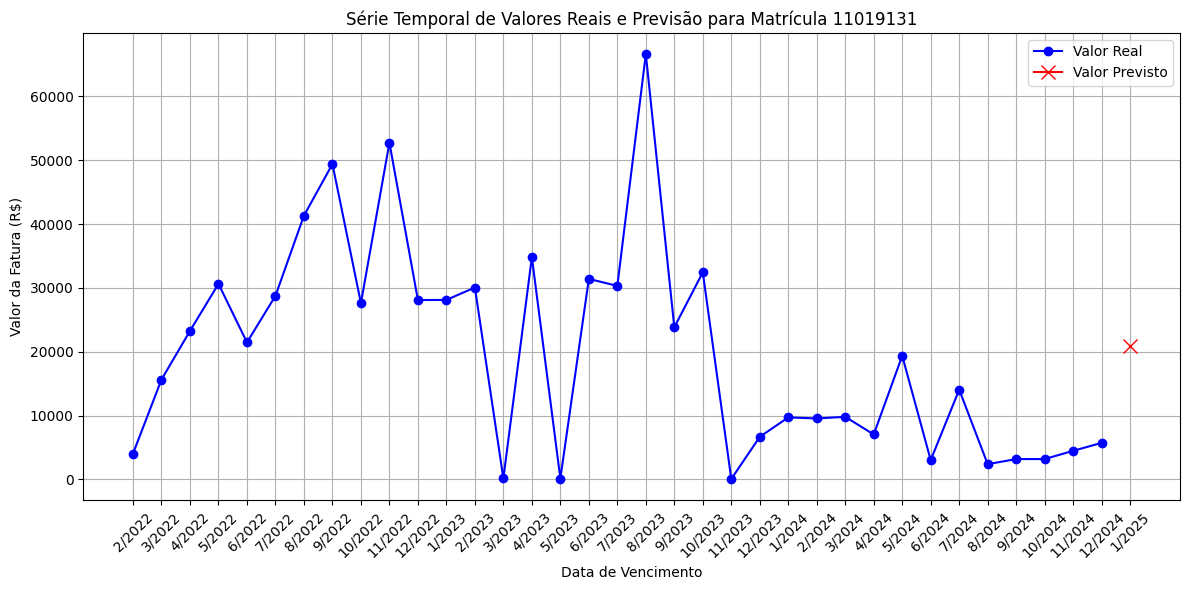

In [17]:
# 

def plotar_serie_e_previsao(matricula, dados_completos, modelo_treinado):
    """
    Função para plotar os valores reais da série temporal de uma matrícula, mostrando as datas das faturas no eixo X
    e o valor futuro previsto.
    
    Args:
        matricula (int): Matrícula para a qual será feita a previsão.
        dados_completos (pd.DataFrame): Conjunto de dados original contendo todas as informações.
        modelo_treinado (Pipeline): Modelo treinado (pipeline).
    """
    # Filtrar os dados históricos da matrícula
    dados_matricula = dados_completos[dados_completos['MATRICULA'] == matricula]

    if dados_matricula.empty:
        print(f"Erro: Matrícula {matricula} não encontrada nos dados fornecidos.")
        return

    # Ordenar os dados pela data de vencimento para consistência na série temporal
    dados_matricula = dados_matricula.sort_values(by=['ANO_VENCIMENTO', 'MES_VENCIMENTO'])

    # Criar coluna de datas legíveis
    dados_matricula['DATA_VENCIMENTO_FORMATADA'] = dados_matricula['MES_VENCIMENTO'].astype(str) + '/' + dados_matricula['ANO_VENCIMENTO'].astype(str)

    # Calcular o valor previsto para o próximo mês
    dados_matricula_resumo = dados_matricula.mean(numeric_only=True)
    dados_matricula_resumo['BAIRRO'] = dados_matricula.iloc[-1]['BAIRRO']
    dados_matricula_resumo['ANO_VENCIMENTO'] = dados_matricula.iloc[-1]['ANO_VENCIMENTO'] + (dados_matricula.iloc[-1]['MES_VENCIMENTO'] // 12)
    dados_matricula_resumo['MES_VENCIMENTO'] = (dados_matricula.iloc[-1]['MES_VENCIMENTO'] % 12) + 1

    # Gerar a entrada para a previsão
    X_entrada = pd.DataFrame([dados_matricula_resumo.drop(['VALOR_FATURA'])])
    valor_previsto = modelo_treinado.predict(X_entrada)[0]

    # Adicionar a próxima data prevista no eixo X
    proximo_mes = (dados_matricula.iloc[-1]['MES_VENCIMENTO'] % 12) + 1
    proximo_ano = dados_matricula.iloc[-1]['ANO_VENCIMENTO'] + (dados_matricula.iloc[-1]['MES_VENCIMENTO'] // 12)
    data_proxima_fatura = f"{proximo_mes}/{proximo_ano}"

    # Plotar série temporal
    plt.figure(figsize=(12, 6))
    plt.plot(dados_matricula['DATA_VENCIMENTO_FORMATADA'], dados_matricula['VALOR_FATURA'], label='Valor Real', color='blue', marker='o')

    # Adicionar o ponto previsto
    plt.plot(data_proxima_fatura, valor_previsto, label='Valor Previsto', color='red', marker='x', markersize=10)

    # Configurar o gráfico
    plt.title(f'Série Temporal de Valores Reais e Previsão para Matrícula {matricula}')
    plt.xlabel('Data de Vencimento')
    plt.ylabel('Valor da Fatura (R$)')
    plt.xticks(rotation=45)  # Rotacionar as labels do eixo X para melhor legibilidade
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


# Exemplo de uso
plotar_serie_e_previsao(matricula, data, best_model)

In [19]:
# 

import joblib

# Salvar o modelo treinado
joblib.dump(best_model, 'base_line.joblib')

['base_line.joblib']